# Goal

In this notebook I want to visualize how mutual information varies with a joint distribution of discrete variables. The variables are specific to a side project, where different statements will be assigned one of 4 stances by each user:
1. True
2. False
3. Unsure
4. Vague

Together with a 5th stance ( unanswered ), we can build informational metrics around it, namely [Mutual Information](https://en.wikipedia.org/wiki/Mutual_information)

Key relations:
- $I(X,Y) = H(X) + H(Y) - H(X,Y)$
- $H(X | Y ) = H(X,Y) - H(Y)$

In [1]:
import random
import itertools
import numpy as np
import pandas as pd
from scipy.stats import entropy
from scipy.optimize import minimize, LinearConstraint
import seaborn as sns
import matplotlib.pyplot as plt
import pprint

mp = pprint.PrettyPrinter(indent=2).pprint

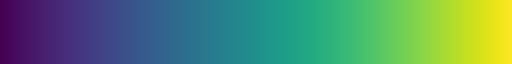

In [2]:
# Colour pallette
sns.color_palette("viridis", as_cmap=True)

In [3]:
stances = ["True", "False", "Unsure", "Vague", "Unanswered"]


class JointDistribution:
    def __init__(self, data=None, baseline=1):
        if data == None:
            data = [
                (a, b, baseline + random.randint(0, 100))
                for a, b in itertools.product(stances, repeat=2)
            ]
        self.votes = pd.DataFrame(
            data=data,
            columns=["statement_a", "statement_b", "votes"],
        )
        self.entropies = {
            "a": entropy(
                list(self.votes.groupby("statement_a").sum()["votes"]), base=2
            ),
            "b": entropy(
                list(self.votes.groupby("statement_b").sum()["votes"]), base=2
            ),
            "total": entropy(self.votes["votes"], base=2),
        }

    def plot(self):
        plt.figure(figsize=(2, 2))
        g = sns.heatmap(
            data=self.votes.pivot(
                index="statement_a", columns="statement_b", values="votes"
            ),
            cmap="viridis",
        )

    def print_information_summary(self):
        mutual_information = {
            "mutual": self.entropies["a"]
            + self.entropies["b"]
            - self.entropies["total"]
        }
        mp(self.entropies | mutual_information)

    @staticmethod
    def from_flat_array(flat_array):
        return JointDistribution(
            data=[
                (a, b, v)
                for (a, b), v in zip(itertools.product(stances, repeat=2), flat_array)
            ]
        )

In [4]:
import math

math.log(5, 2)

2.321928094887362

{ 'a': 2.3219280948873626,
  'b': 2.3219280948873626,
  'mutual': 2.321925933437947,
  'total': 2.321930256336778}


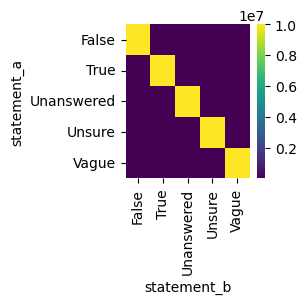

In [5]:
baseline = 0.2
jd = JointDistribution(
    data=[
        (a, b, 10**7 if a == b else baseline)
        for a, b in itertools.product(stances, repeat=2)
    ]
)
jd.print_information_summary()
jd.plot()

In [6]:
jd.votes.pivot(index="statement_a", columns="statement_b", values="votes")

statement_b,False,True,Unanswered,Unsure,Vague
statement_a,,,,,
False,10000000.0,0.2,0.2,0.2,0.2
True,0.2,10000000.0,0.2,0.2,0.2
Unanswered,0.2,0.2,10000000.0,0.2,0.2
Unsure,0.2,0.2,0.2,10000000.0,0.2
Vague,0.2,0.2,0.2,0.2,10000000.0


## Mini problem

I want to find the joint distribution that minimizes $H(X|Y)/H(Y|X)$. We will do this by setting a length 25 vector, and search over this space, using the ration below as a loss function

In [7]:
def loss_function(vector: np.ndarray) -> float:
    jd = JointDistribution.from_flat_array(vector)
    return np.divide(
        jd.entropies["total"] - jd.entropies["b"],
        jd.entropies["total"] - jd.entropies["a"],
    )

{ 'a': 0.33130417395663075,
  'b': 2.3190685244401816,
  'mutual': 0.0001242303432835712,
  'total': 2.6502484680535288}


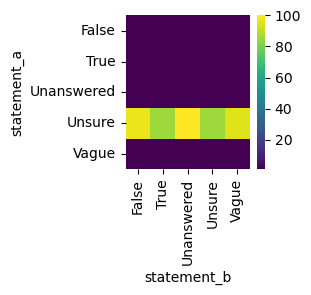

In [9]:
x = minimize(
    x0=[random.randint(1, 5) for _ in range(25)],
    # x0=x.x,
    fun=loss_function,
    method="SLSQP",
    constraints={
        LinearConstraint(
            A=np.diag(np.ones(25)), ub=np.divide(np.ones(25), 0.01), lb=np.ones(25)
        )
    },
)
minimal_jd = JointDistribution.from_flat_array(x.x)
minimal_jd.print_information_summary()
minimal_jd.plot()

From this experiment it seems like the ratio is minimized when we roughly have a uniform distribution on the possible pairs, but we make the entropy of a minimal by only allowing 2 values, and the entropy of b maximal by allowing all values.